In [1]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import sys

sys.path.append("../")

from src.common_functions import *

In [2]:
# sample data
# RAW_DATA_PATH = "../datasets/fraud/fin_fraud.csv"
SAMPLED_DATA_PATH = "../datasets/fraud/cc_fraud_1.csv"
DATASET_NAME = Path(SAMPLED_DATA_PATH).stem
# raw_data = pd.read_csv(RAW_DATA_PATH)
# raw_data = raw_data.rename(columns=dict(zip(raw_data.columns, list(map(to_snake_case, raw_data.columns)))))
# raw_data.head()
# _to_drop, df = train_test_split(raw_data, test_size=0.1, random_state=42, stratify=raw_data["fraud"])
# df.to_csv(SAMPLED_DATA_PATH, header=True, sep=",")
# del _to_drop
df = pd.read_csv(SAMPLED_DATA_PATH)
print(df.shape[0])
df.fraud.value_counts()/df.shape[0]*100

100000


fraud
0.0    91.26
1.0     8.74
Name: count, dtype: float64

In [3]:
df.isna().any()

Unnamed: 0                        False
distance_from_home                False
distance_from_last_transaction    False
ratio_to_median_purchase_price    False
repeat_retailer                   False
used_chip                         False
used_pin_number                   False
online_order                      False
fraud                             False
dtype: bool

In [4]:
df.head()

,Unnamed: 0,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,748493,40.751310,1.640059,0.563163,1.0,1.0,0.0,1.0,0.0
1,924852,1.282625,0.104560,0.349388,0.0,0.0,0.0,0.0,0.0
2,421808,20.369739,0.059844,0.327433,1.0,1.0,0.0,1.0,0.0
3,526416,10.537379,0.960467,0.232489,1.0,0.0,0.0,0.0,0.0
4,152659,8.519601,0.266422,3.804493,1.0,0.0,0.0,0.0,0.0


In [5]:
y = "fraud"

# some generic cleaning

COLUMNS_TO_DROP = []
assert df[y].isna().any() == False
raw_features = df.drop(COLUMNS_TO_DROP, axis=1)

# ML tuning

train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=df[y])

fit_le = LabelEncoder().fit(train[y])

In [6]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': [6,8,10,12],
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

model = LogisticRegression()

MODEL_NAME = 'logistic'

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, model=model, fit_le=fit_le, model_name='logistic', param_grid=param_grid, verbose=1)
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
2160 fits failed out of a total of 2880.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1440 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^

Best score: 0.9796419601916291
Best parameters: {'logistic__C': 10, 'logistic__penalty': 'l2', 'over__sampling_strategy': 1, 'pca__n_components': 8, 'under__sampling_strategy': 0.7}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Unnamed: 0',
                                                   'distance_from_home',
                                                   'distance_from_last_transaction',
                                                   'ratio_to_median_purchase_price',
                                                   'repeat_retailer',
                                                   'used_chip',
                                                   'used_pin_number',
                                                   'online_order']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  [])])),
                ('under', RandomUnderSampler(sampling_strategy=0.7)),
                ('over', SMOTE(sampling_strategy=1)),
                ('pca', PCA(n_components=8)),
                ('logistic', LogisticRegression(C=10))])

In [7]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

In [8]:
COLUMNS = ["under__sampling_strategy", "over__sampling_strategy", "pca__n_components", f"{MODEL_NAME}__C", f"{MODEL_NAME}__penalty", "roc_auc_mean", "roc_auc_std"]

pd.concat([
    pd.DataFrame(grid.cv_results_["params"]),
    pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["roc_auc_mean"]),
    pd.DataFrame(grid.cv_results_["std_test_score"], columns=["roc_auc_std"])
    ],axis=1).dropna(subset=["roc_auc_mean", "roc_auc_std"])[COLUMNS].sort_values(by=COLUMNS)

,under__sampling_strategy,over__sampling_strategy,pca__n_components,logistic__C,logistic__penalty,roc_auc_mean,roc_auc_std
0,0.1,0.2,6,1,l2,0.970486,0.002546
144,0.1,0.2,6,10,l2,0.969887,0.002072
288,0.1,0.2,6,100,l2,0.970020,0.002685
432,0.1,0.2,6,1000,l2,0.970039,0.003089
6,0.1,0.2,8,1,l2,0.973287,0.003203
...,...,...,...,...,...,...,...
556,0.7,1.0,6,1000,l2,0.966517,0.000793
130,0.7,1.0,8,1,l2,0.979581,0.000786
274,0.7,1.0,8,10,l2,0.979642,0.000794
418,0.7,1.0,8,100,l2,0.979505,0.000871


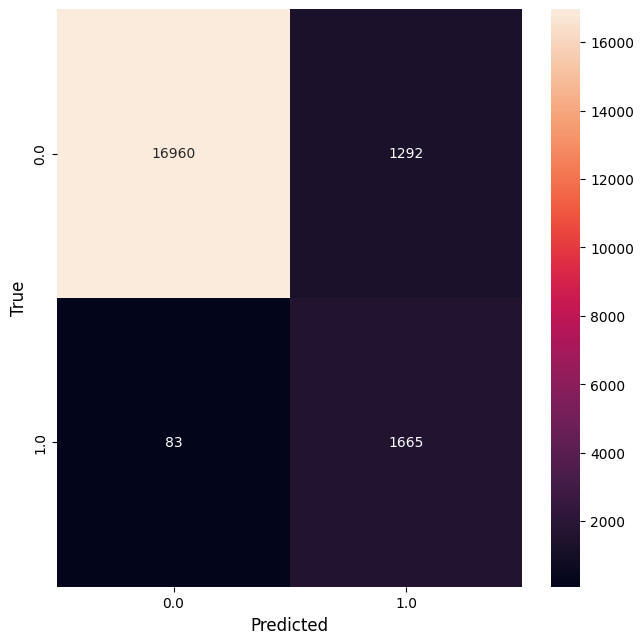

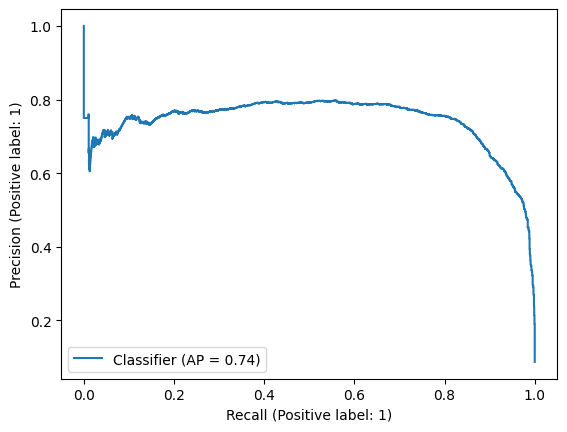

In [9]:
evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=test, y_col_name=y, model_name= 'logistic')

In [10]:
param_grid_xgb = {
    'xgb__objective': ['binary:logistic'],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5],
    'pca__n_components': [8, 20, 25, 30, 35, 50, 65],
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

xgb = XGBClassifier()

MODEL_NAME = "xgb"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, fit_le=fit_le, model_name=MODEL_NAME, model=xgb, param_grid=param_grid_xgb, n_folds=5, verbose=1, randomized = True)
best_pipeline_xgb = grid.best_estimator_
best_pipeline_xgb

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^

Best score: 0.9998244748255034
Best parameters: {'xgb__subsample': 0.6, 'xgb__objective': 'binary:logistic', 'xgb__min_child_weight': 5, 'xgb__max_depth': 4, 'xgb__gamma': 2, 'xgb__colsample_bytree': 0.8, 'under__sampling_strategy': 0.1, 'pca__n_components': 8, 'over__sampling_strategy': 0.7}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Unnamed: 0',
                                                   'distance_from_home',
                                                   'distance_from_last_transaction',
                                                   'ratio_to_median_purchase_price',
                                                   'repeat_retailer',
                                                   'used_chip',
                                                   'used_pin_number',
                                                   'online_order']),
                                                 ('cat',
                                                  Pipeline(ste...
                               feature_types=None, gamma=2, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [11]:
write_pipeline(best_pipeline_xgb, MODEL_NAME, DATASET_NAME)

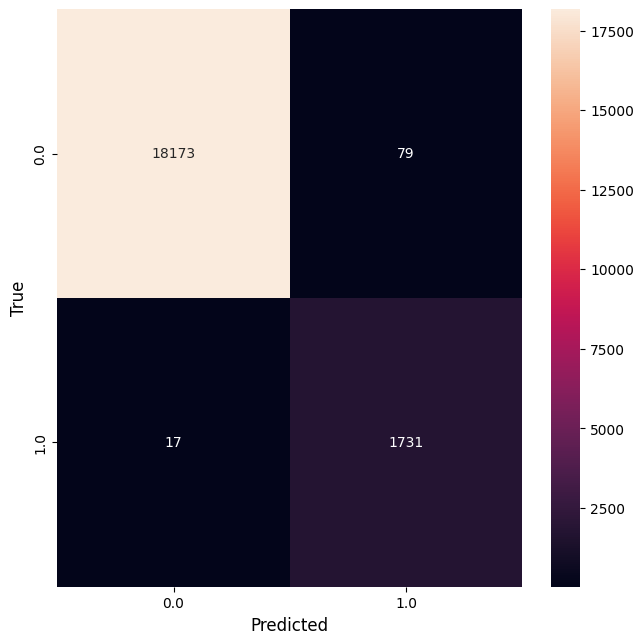

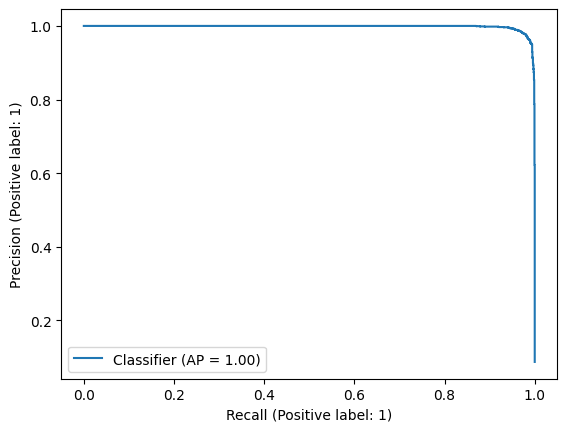

In [12]:
evaluate_model(best_pipeline_xgb, fit_le=fit_le, test=test, y_col_name=y, model_name=MODEL_NAME)

In [13]:
MODEL_NAME='logistic'
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)
MODEL_NAME='xgb'
best_pipeline_xgb = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

# evaluation metrics

In [14]:
test_predictions_log = test.copy(deep=True)
test_predictions_log["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log.drop(y, axis=1))
test_predictions_log["churn_encoded"] = fit_le.transform(test_predictions_log["fraud"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log['A'] = impute.fit_transform(
    (test_predictions_log["ratio_to_median_purchase_price"]*20000).to_frame())[:, 0]
# scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
# test_predictions_log['A'] = scaler.fit_transform(test_predictions_log['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log['instance_cost'] = test_predictions_log.apply(lambda row: instance_dependent_cost_fraud(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log[['fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log['instance_cost'].sum()/len(test_predictions_log))

Test cost/loss = 3223.
 total cost/loss average :  0.1611497122969399


In [15]:
print(test_predictions_log[['fraud', "A", 'instance_cost', 'y_predicted']].iloc[31:60])

       fraud              A  instance_cost  y_predicted
93892    0.0   10388.575914            0.0            0
20476    0.0   20414.840639            0.0            0
63548    0.0   14500.144617            0.0            0
99540    0.0   39799.740486            0.0            0
95543    0.0   43552.021289            0.0            0
23442    0.0    1737.407830            0.0            0
46527    0.0   34235.447023            0.0            0
10440    0.0    2822.560402            0.0            0
69763    0.0   20482.125038            0.0            0
38100    0.0   49965.529112            0.0            0
58622    0.0    6908.669945            0.0            0
34753    0.0   24230.205841            0.0            0
47355    0.0   46401.692821            0.0            0
77435    0.0    8750.969916            0.0            0
37768    0.0   13212.412937            0.0            0
47313    0.0    4876.795685            0.0            0
20416    0.0   11576.828326            0.0      

In [16]:
test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb.drop(y, axis=1))
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["fraud"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb['A'] = impute.fit_transform(
    (test_predictions_xgb["ratio_to_median_purchase_price"]*20000).to_frame())[:, 0]
# scaler = MinMaxScaler()

# # Fit and transform the cb_column using the scaler
# test_predictions_xgb['A'] = scaler.fit_transform(test_predictions_xgb['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost_fraud(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb[['fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb['instance_cost'].sum()/len(test_predictions_xgb))

Test cost/loss = 739.
 total cost/loss average :  0.03696404021411442


In [17]:
print(test_predictions_xgb[['fraud', "A", 'instance_cost', 'y_predicted']].iloc[150:180])

       fraud              A  instance_cost  y_predicted
91750    0.0   14725.285119            0.0            0
64367    0.0   22276.493375            0.0            0
48751    0.0  103176.312134            0.0            0
82817    0.0    8774.705591            0.0            0
45708    0.0   49619.184337            0.0            0
65195    0.0   16326.058735            0.0            0
21682    1.0   84920.824612            0.0            1
99183    0.0    8316.316780            0.0            0
59       0.0    5534.458173            0.0            0
89148    0.0    1339.907341            0.0            0
97895    0.0   15115.433639            0.0            0
29979    0.0   11085.245838            0.0            0
18693    0.0   21629.190410            0.0            0
62996    0.0  144244.013733            0.0            0
4927     0.0   18929.378659            0.0            0
15940    0.0   30900.912178            0.0            0
65106    0.0     643.533788            0.0      

# amc-metric

Decision Threshold: 0.01, Test cost/loss = 10363.00
Decision Threshold: 0.02, Test cost/loss = 9120.00
Decision Threshold: 0.03, Test cost/loss = 7898.00
Decision Threshold: 0.04, Test cost/loss = 6970.10
Decision Threshold: 0.05, Test cost/loss = 6372.43
Decision Threshold: 0.06, Test cost/loss = 5852.43
Decision Threshold: 0.07, Test cost/loss = 5438.80
Decision Threshold: 0.08, Test cost/loss = 5087.80
Decision Threshold: 0.09, Test cost/loss = 4854.65
Decision Threshold: 0.10, Test cost/loss = 4578.65
Decision Threshold: 0.11, Test cost/loss = 4388.72
Decision Threshold: 0.12, Test cost/loss = 4270.28
Decision Threshold: 0.13, Test cost/loss = 4052.28
Decision Threshold: 0.14, Test cost/loss = 3954.75
Decision Threshold: 0.15, Test cost/loss = 3905.30
Decision Threshold: 0.16, Test cost/loss = 3764.30
Decision Threshold: 0.17, Test cost/loss = 3743.29
Decision Threshold: 0.18, Test cost/loss = 3691.78
Decision Threshold: 0.19, Test cost/loss = 3586.78
Decision Threshold: 0.20, Test

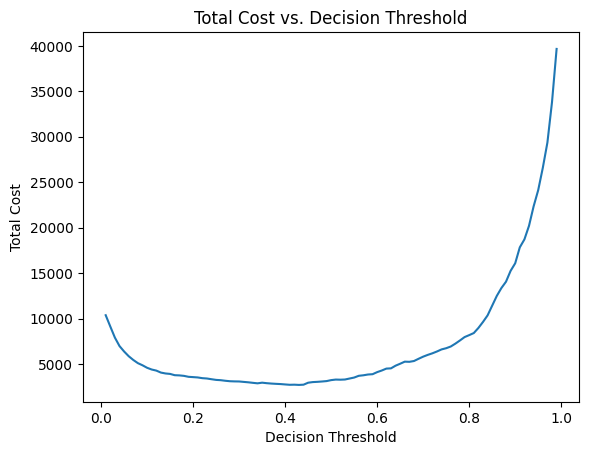

In [18]:
cb_column = 'A'
test_predictions_log['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold(test_predictions_log, best_pipeline_log_reg, y,cb_column, y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type = 'fraud')

Decision Threshold: 0.01, Test cost/loss = 713.15
Decision Threshold: 0.02, Test cost/loss = 530.15
Decision Threshold: 0.03, Test cost/loss = 499.15
Decision Threshold: 0.04, Test cost/loss = 450.15
Decision Threshold: 0.05, Test cost/loss = 410.15
Decision Threshold: 0.06, Test cost/loss = 492.91
Decision Threshold: 0.07, Test cost/loss = 467.91
Decision Threshold: 0.08, Test cost/loss = 451.91
Decision Threshold: 0.09, Test cost/loss = 453.59
Decision Threshold: 0.10, Test cost/loss = 447.59
Decision Threshold: 0.11, Test cost/loss = 624.84
Decision Threshold: 0.12, Test cost/loss = 614.84
Decision Threshold: 0.13, Test cost/loss = 610.84
Decision Threshold: 0.14, Test cost/loss = 645.87
Decision Threshold: 0.15, Test cost/loss = 639.87
Decision Threshold: 0.16, Test cost/loss = 640.76
Decision Threshold: 0.17, Test cost/loss = 633.76
Decision Threshold: 0.18, Test cost/loss = 630.76
Decision Threshold: 0.19, Test cost/loss = 625.76
Decision Threshold: 0.20, Test cost/loss = 621.76


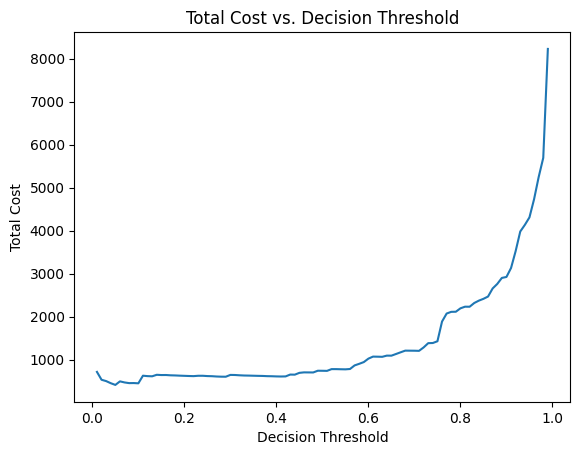

In [19]:
test_predictions_xgb['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(test_predictions_xgb, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type= 'fraud' )

# e-amc metric


In [20]:
test_predictions_log = add_eap_ep(
    train=train, 
    test=test_predictions_log, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1.0, 
    instance_dependent_cost_type="fraud")
test_predictions_xgb = add_eap_ep(
    train=train, 
    test=test_predictions_xgb, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1.0, 
    instance_dependent_cost_type="fraud")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:314: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [21]:
test_predictions_log

,Unnamed: 0,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,y_predicted,...,A,instance_cost,y_predicted_decoded,y_predicted_proba_log,TN,FN,FP,TP,EAP,EP
68616,78690,7.068874,0.009902,0.271620,1.0,1.0,0.0,1.0,0.0,0,...,5432.400509,0.000000,0.0,0.005472,0,2.716200,1,0,5.471559e-03,0.087400
5708,445743,34.237785,0.184516,1.314701,1.0,0.0,0.0,1.0,0.0,0,...,26294.025018,0.000000,0.0,0.163703,0,13.147013,1,0,1.637035e-01,0.087400
378,673648,20.534527,1.814480,1.464470,1.0,0.0,0.0,1.0,0.0,0,...,29289.390585,0.000000,0.0,0.143568,0,14.644695,1,0,1.435677e-01,0.087400
10881,747113,11.542966,0.016548,1.016061,1.0,0.0,0.0,0.0,0.0,0,...,20321.210539,0.000000,0.0,0.000245,0,10.160605,1,0,2.445052e-04,0.087400
99380,327658,25.213016,1.191400,0.429776,1.0,0.0,0.0,1.0,0.0,0,...,8595.528192,0.000000,0.0,0.045467,0,4.297764,1,0,4.546709e-02,0.087400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39683,230329,20.469879,14.099746,4.742546,1.0,1.0,0.0,1.0,1.0,1,...,94850.914540,47.425457,1.0,0.878432,0,47.425457,1,0,5.765420e+00,43.280472
91505,711003,3.692470,24.722785,4.021248,1.0,1.0,0.0,1.0,1.0,1,...,80424.956817,40.212478,1.0,0.744417,0,40.212478,1,0,1.027763e+01,36.697908
29358,942694,1.719811,0.666478,14.330479,0.0,1.0,0.0,1.0,1.0,1,...,286609.586793,0.000000,1.0,1.000000,0,143.304793,1,0,4.759139e-05,130.779954
27461,636954,2.936629,0.341577,19.370925,1.0,1.0,0.0,1.0,1.0,1,...,387418.501075,0.000000,1.0,1.000000,0,193.709251,1,0,3.606614e-07,176.779062


In [22]:
test_predictions_xgb

,Unnamed: 0,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,y_predicted,...,A,instance_cost,y_predicted_decoded,y_predicted_proba_xgb,TN,FN,FP,TP,EAP,EP
68616,78690,7.068874,0.009902,0.271620,1.0,1.0,0.0,1.0,0.0,0,...,5432.400509,0.000000,0.0,1.554114e-07,0,2.716200,1,0,1.554114e-07,0.087400
5708,445743,34.237785,0.184516,1.314701,1.0,0.0,0.0,1.0,0.0,0,...,26294.025018,0.000000,0.0,3.496389e-05,0,13.147013,1,0,3.496389e-05,0.087400
378,673648,20.534527,1.814480,1.464470,1.0,0.0,0.0,1.0,0.0,0,...,29289.390585,0.000000,0.0,6.535356e-06,0,14.644695,1,0,6.535356e-06,0.087400
10881,747113,11.542966,0.016548,1.016061,1.0,0.0,0.0,0.0,0.0,0,...,20321.210539,0.000000,0.0,4.758500e-07,0,10.160605,1,0,4.758500e-07,0.087400
99380,327658,25.213016,1.191400,0.429776,1.0,0.0,0.0,1.0,0.0,0,...,8595.528192,0.000000,0.0,2.980330e-06,0,4.297764,1,0,2.980330e-06,0.087400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39683,230329,20.469879,14.099746,4.742546,1.0,1.0,0.0,1.0,1.0,1,...,94850.914540,0.000000,1.0,9.998293e-01,0,47.425457,1,0,8.095891e-03,43.280472
91505,711003,3.692470,24.722785,4.021248,1.0,1.0,0.0,1.0,1.0,1,...,80424.956817,40.212478,1.0,7.927120e-01,0,40.212478,1,0,8.335565e+00,36.697908
29358,942694,1.719811,0.666478,14.330479,0.0,1.0,0.0,1.0,1.0,1,...,286609.586793,0.000000,1.0,9.990579e-01,0,143.304793,1,0,1.350005e-01,130.779954
27461,636954,2.936629,0.341577,19.370925,1.0,1.0,0.0,1.0,1.0,1,...,387418.501075,0.000000,1.0,9.999435e-01,0,193.709251,1,0,1.094558e-02,176.779062


In [23]:
print(test_predictions_log['EAP'].sum())
print(test_predictions_log['EP'].sum())


print('EAP : ', test_predictions_log['EAP'].sum()/len(test_predictions_log))
print('EP : ', test_predictions_log['EP'].sum()/len(test_predictions_log))

7372.2602245349135
92684.69795145269
EAP :  0.36861301122674567
EP :  4.634234897572634


In [24]:
print(test_predictions_xgb['EAP'].sum())
print(test_predictions_xgb['EP'].sum())


print('EAP : ', test_predictions_xgb['EAP'].sum()/len(test_predictions_xgb))
print('EP : ', test_predictions_xgb['EP'].sum()/len(test_predictions_xgb))

1437.0986122409342
92684.69795145269
EAP :  0.07185493061204672
EP :  4.634234897572634


# MP at 50% threshold

In [25]:
test_predictions_log_2= test.copy(deep=True)
test_predictions_log_2["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_2.drop(y, axis=1))
test_predictions_log_2["churn_encoded"] = fit_le.transform(test_predictions_log_2["fraud"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_2['A'] = impute.fit_transform(
    (test_predictions_log_2["ratio_to_median_purchase_price"]*20000).to_frame())[:, 0]
# scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
# test_predictions_log['A'] = scaler.fit_transform(test_predictions_log['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_2['instance_cost'] = test_predictions_log_2.apply(lambda row: instance_dependent_cost_fraud_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_2[['fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_2['instance_cost'].sum()/len(test_predictions_log_2))

Test cost/loss = -1558.
 total cost/loss average :  -0.07789971229693987


In [26]:
test_predictions_xgb_2 = test.copy(deep=True)
test_predictions_xgb_2["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_2.drop(y, axis=1))
test_predictions_xgb_2["churn_encoded"] = fit_le.transform(test_predictions_xgb_2["fraud"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_2['A'] = impute.fit_transform(
    (test_predictions_xgb_2["ratio_to_median_purchase_price"]*20000).to_frame())[:, 0]
# scaler = MinMaxScaler()

# # Fit and transform the cb_column using the scaler
# test_predictions_xgb['A'] = scaler.fit_transform(test_predictions_xgb['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_2['instance_cost'] = test_predictions_xgb_2.apply(lambda row: instance_dependent_cost_fraud_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_2[['fraud', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_2['instance_cost'].sum()/len(test_predictions_xgb_2))

Test cost/loss = 992.
 total cost/loss average :  0.04958595978588558


In [27]:
test_predictions_log_2

,Unnamed: 0,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded
68616,78690,7.068874,0.009902,0.271620,1.0,1.0,0.0,1.0,0.0,0,0,5432.400509,0.0,0.0
5708,445743,34.237785,0.184516,1.314701,1.0,0.0,0.0,1.0,0.0,0,0,26294.025018,0.0,0.0
378,673648,20.534527,1.814480,1.464470,1.0,0.0,0.0,1.0,0.0,0,0,29289.390585,0.0,0.0
10881,747113,11.542966,0.016548,1.016061,1.0,0.0,0.0,0.0,0.0,0,0,20321.210539,0.0,0.0
99380,327658,25.213016,1.191400,0.429776,1.0,0.0,0.0,1.0,0.0,0,0,8595.528192,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,134541,92.077196,0.004849,5.896882,1.0,1.0,0.0,1.0,1.0,1,1,117937.633359,1.0,1.0
99422,200381,6.237010,1.860237,2.667288,1.0,1.0,0.0,1.0,0.0,0,0,53345.754037,0.0,0.0
40032,28631,24.032659,0.180503,0.495413,1.0,0.0,0.0,1.0,0.0,0,0,9908.266408,0.0,0.0
38101,974170,21.272029,1.104873,2.022286,1.0,1.0,0.0,0.0,0.0,0,0,40445.714357,0.0,0.0


In [28]:
test_predictions_xgb_2

,Unnamed: 0,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded
68616,78690,7.068874,0.009902,0.271620,1.0,1.0,0.0,1.0,0.0,0,0,5432.400509,0.0,0.0
5708,445743,34.237785,0.184516,1.314701,1.0,0.0,0.0,1.0,0.0,0,0,26294.025018,0.0,0.0
378,673648,20.534527,1.814480,1.464470,1.0,0.0,0.0,1.0,0.0,0,0,29289.390585,0.0,0.0
10881,747113,11.542966,0.016548,1.016061,1.0,0.0,0.0,0.0,0.0,0,0,20321.210539,0.0,0.0
99380,327658,25.213016,1.191400,0.429776,1.0,0.0,0.0,1.0,0.0,0,0,8595.528192,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,134541,92.077196,0.004849,5.896882,1.0,1.0,0.0,1.0,1.0,1,1,117937.633359,1.0,1.0
99422,200381,6.237010,1.860237,2.667288,1.0,1.0,0.0,1.0,0.0,0,0,53345.754037,0.0,0.0
40032,28631,24.032659,0.180503,0.495413,1.0,0.0,0.0,1.0,0.0,0,0,9908.266408,0.0,0.0
38101,974170,21.272029,1.104873,2.022286,1.0,1.0,0.0,0.0,0.0,0,0,40445.714357,0.0,0.0


# MP-metric

In [29]:
cb_column = 'A'
test_predictions_log_2['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log_2.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold_2(test_predictions_log_2, best_pipeline_log_reg, y,cb_column, y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type = 'fraud_2')


Decision Threshold: 0.01, Test cost/loss = -8615.00
Decision Threshold: 0.02, Test cost/loss = -7372.00
Decision Threshold: 0.03, Test cost/loss = -6150.00
Decision Threshold: 0.04, Test cost/loss = -5223.10
Decision Threshold: 0.05, Test cost/loss = -4626.43
Decision Threshold: 0.06, Test cost/loss = -4106.43
Decision Threshold: 0.07, Test cost/loss = -3693.80
Decision Threshold: 0.08, Test cost/loss = -3342.80
Decision Threshold: 0.09, Test cost/loss = -3111.65
Decision Threshold: 0.10, Test cost/loss = -2835.65
Decision Threshold: 0.11, Test cost/loss = -2646.72
Decision Threshold: 0.12, Test cost/loss = -2530.28
Decision Threshold: 0.13, Test cost/loss = -2312.28
Decision Threshold: 0.14, Test cost/loss = -2216.75
Decision Threshold: 0.15, Test cost/loss = -2170.30
Decision Threshold: 0.16, Test cost/loss = -2029.30
Decision Threshold: 0.17, Test cost/loss = -2011.29
Decision Threshold: 0.18, Test cost/loss = -1960.78
Decision Threshold: 0.19, Test cost/loss = -1855.78
Decision Thr

TypeError: unsupported format string passed to NoneType.__format__

Decision Threshold: 0.01, Test cost/loss = 1033.85
Decision Threshold: 0.02, Test cost/loss = 1216.85
Decision Threshold: 0.03, Test cost/loss = 1246.85
Decision Threshold: 0.04, Test cost/loss = 1295.85
Decision Threshold: 0.05, Test cost/loss = 1335.85
Decision Threshold: 0.06, Test cost/loss = 1252.09
Decision Threshold: 0.07, Test cost/loss = 1277.09
Decision Threshold: 0.08, Test cost/loss = 1293.09
Decision Threshold: 0.09, Test cost/loss = 1290.41
Decision Threshold: 0.10, Test cost/loss = 1296.41
Decision Threshold: 0.11, Test cost/loss = 1118.16
Decision Threshold: 0.12, Test cost/loss = 1128.16
Decision Threshold: 0.13, Test cost/loss = 1132.16
Decision Threshold: 0.14, Test cost/loss = 1096.13
Decision Threshold: 0.15, Test cost/loss = 1102.13
Decision Threshold: 0.16, Test cost/loss = 1100.24
Decision Threshold: 0.17, Test cost/loss = 1107.24
Decision Threshold: 0.18, Test cost/loss = 1110.24
Decision Threshold: 0.19, Test cost/loss = 1115.24
Decision Threshold: 0.20, Test 

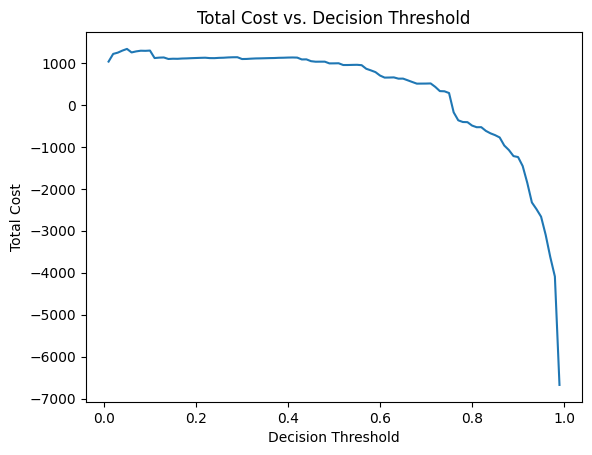

In [30]:
test_predictions_xgb_2['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb_2.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(test_predictions_xgb_2, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type= 'fraud_2' )

# Emp

In [31]:
test_predictions_log_2 = add_eap_ep(
    train=train, 
    test=test_predictions_log_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1.0, 
    instance_dependent_cost_type="fraud_2")
test_predictions_xgb_2 = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1.0, 
    instance_dependent_cost_type="fraud_2")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:314: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [32]:
print(test_predictions_log_2['EAP'].sum())
print(test_predictions_log_2['EP'].sum())


print('EAP : ', test_predictions_log_2['EAP'].sum()/len(test_predictions_log_2))
print('EP : ', test_predictions_log_2['EP'].sum()/len(test_predictions_log_2))

-5801.098889426177
-92531.92275145269
EAP :  -0.29005494447130886
EP :  -4.626596137572634


In [33]:
print(test_predictions_xgb_2['EAP'].sum())
print(test_predictions_xgb_2['EP'].sum())


print('EAP : ', test_predictions_xgb_2['EAP'].sum()/len(test_predictions_xgb_2))
print('EP : ', test_predictions_xgb_2['EP'].sum()/len(test_predictions_xgb_2))

279.77705896068414
-92531.92275145269
EAP :  0.013988852948034208
EP :  -4.626596137572634


# MP

In [ ]:
def instance_dependent_cost_2(prediction: int, encoded_true_label: int, a: float) -> float:
    
    if encoded_true_label == 1 and prediction == 1:  # True Positive (TP)
        return 1 - a*10
    elif encoded_true_label == 0 and prediction == 1:  # False Positive (FP)
        return 1
    elif encoded_true_label == 0 and prediction == 0:  # True Negative (TN)0
        return 0
    elif encoded_true_label == 1 and prediction == 0:  # False Negative (FN)
        return a*10

Decision Threshold: 0.01, Test cost/loss = -87696.14
Decision Threshold: 0.02, Test cost/loss = -88905.14
Decision Threshold: 0.03, Test cost/loss = -90101.14
Decision Threshold: 0.04, Test cost/loss = -91038.95
Decision Threshold: 0.05, Test cost/loss = -91613.28
Decision Threshold: 0.06, Test cost/loss = -92044.55
Decision Threshold: 0.07, Test cost/loss = -92487.55
Decision Threshold: 0.08, Test cost/loss = -92684.85
Decision Threshold: 0.09, Test cost/loss = -92991.85
Decision Threshold: 0.10, Test cost/loss = -93084.87
Decision Threshold: 0.11, Test cost/loss = -93258.57
Decision Threshold: 0.12, Test cost/loss = -93265.65
Decision Threshold: 0.13, Test cost/loss = -93475.65
Decision Threshold: 0.14, Test cost/loss = -93497.60
Decision Threshold: 0.15, Test cost/loss = -93450.98
Decision Threshold: 0.16, Test cost/loss = -93484.93
Decision Threshold: 0.17, Test cost/loss = -93620.93
Decision Threshold: 0.18, Test cost/loss = -93506.21
Decision Threshold: 0.19, Test cost/loss = -93

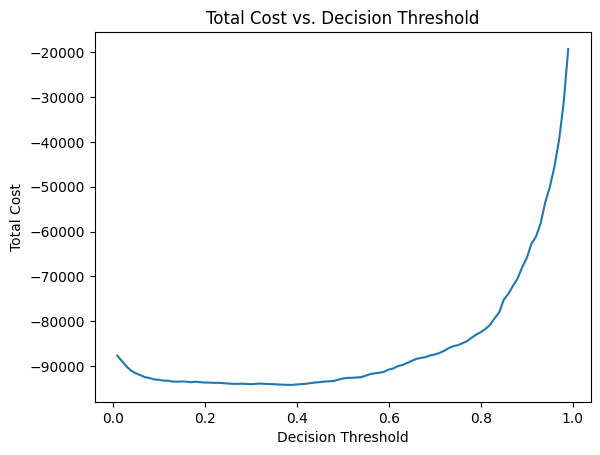

(0.39, -4.710888962235905, -94217.7792447181)

In [ ]:
def compute_best_threshold(test, log_best, y_encoded_col_name, cb_column):
    thresholds = np.linspace(0.01, 0.99, 99)

    lowest_cost = float('inf')  # Initialize with positive infinity
    best_threshold = None
    total_costs = []  # Store total costs for each threshold
    test['y_predicted_proba']= log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
    # impute = SimpleImputer(strategy='median')
    # test_predictions[cb_column] = impute.fit_transform(
    # (test_predictions[cb_column]).to_frame())[:, 0]

    for decision_threshold in thresholds:
        test['instance_cost'] = test.apply(lambda row: instance_dependent_cost_2(
            row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
        total_cost = test['instance_cost'].sum()
        total_costs.append(total_cost)
        print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
        
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = decision_threshold

    AMC = lowest_cost / len(test)

    # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
    print(f"Best Decision Threshold: {best_threshold:.2f}, max profit = {abs(lowest_cost):.2f}, max profit average = {abs(AMC):.2f}")

    plt.plot(thresholds, total_costs)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Total Cost vs. Decision Threshold')
    plt.show()

    return best_threshold, AMC, lowest_cost
compute_best_threshold(test, best_pipeline_log_reg, y, 'cb')

Decision Threshold: 0.01, Test cost/loss = -97170.83
Decision Threshold: 0.02, Test cost/loss = -97342.83
Decision Threshold: 0.03, Test cost/loss = -97417.83
Decision Threshold: 0.04, Test cost/loss = -97473.83
Decision Threshold: 0.05, Test cost/loss = -97509.83
Decision Threshold: 0.06, Test cost/loss = -97544.83
Decision Threshold: 0.07, Test cost/loss = -97558.48
Decision Threshold: 0.08, Test cost/loss = -97582.48
Decision Threshold: 0.09, Test cost/loss = -97598.48
Decision Threshold: 0.10, Test cost/loss = -97611.48
Decision Threshold: 0.11, Test cost/loss = -97624.48
Decision Threshold: 0.12, Test cost/loss = -97633.48
Decision Threshold: 0.13, Test cost/loss = -97644.48
Decision Threshold: 0.14, Test cost/loss = -97652.48
Decision Threshold: 0.15, Test cost/loss = -97659.48
Decision Threshold: 0.16, Test cost/loss = -97667.48
Decision Threshold: 0.17, Test cost/loss = -97662.42
Decision Threshold: 0.18, Test cost/loss = -97667.42
Decision Threshold: 0.19, Test cost/loss = -97

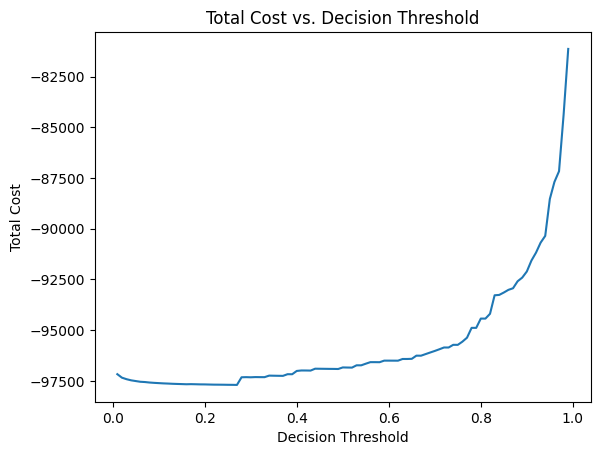

(0.27, -4.885020773224022, -97700.41546448044)

In [ ]:
def compute_best_threshold(test, xgb_best, y_encoded_col_name, cb_column):
    thresholds = np.linspace(0.01, 0.99, 99)

    lowest_cost = float('inf')  # Initialize with positive infinity
    best_threshold = None
    total_costs = []  # Store total costs for each threshold
    test_predictions_xgb['y_predicted_proba']= xgb_best.predict_proba(test_predictions_xgb.drop(y_encoded_col_name, axis=1))[:, 1]
    # impute = SimpleImputer(strategy='median')
    # test_predictions[cb_column] = impute.fit_transform(
    # (test_predictions[cb_column]).to_frame())[:, 0]

    for decision_threshold in thresholds:
        test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost_2(
            row['y_predicted_proba'] >= decision_threshold, row[y_encoded_col_name], row[cb_column]), axis=1)
        
        total_cost = test_predictions_xgb['instance_cost'].sum()
        total_costs.append(total_cost)
        print(f"Decision Threshold: {decision_threshold:.2f}, Test cost/loss = {total_cost:.2f}")
        
        if total_cost < lowest_cost:
            lowest_cost = total_cost
            best_threshold = decision_threshold

    AMC = lowest_cost / len(test)

    # print(f"Best Decision Threshold: {best_threshold:.2f}, lowest_cost = {lowest_cost:.2f}" )
    print(f"Best Decision Threshold: {best_threshold:.2f}, max profit = {abs(lowest_cost):.2f}, max profit average = {abs(AMC):.2f}")

    plt.plot(thresholds, total_costs)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Total Cost')
    plt.title('Total Cost vs. Decision Threshold')
    plt.show()

    return best_threshold, AMC, lowest_cost
compute_best_threshold(test_predictions_xgb, best_pipeline_xgb, y, 'cb')